## Take home assignment - NC

This notebook contains the assignment for Natural Cycles take home assignment.


In [1]:
## --- Import needed libraries

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score

from lifelines import KaplanMeierFitter, statistics,CoxPHFitter
from lifelines.utils import median_survival_times

%matplotlib inline
import matplotlib.pyplot as plt

## Set Seaborn Theme
sns.set_theme()

## Set Color Palette for plots
# Create a custom palette using HEX codes 
#hex = sns.color_palette(["#FF6B6B", "#4ECDC4", "#45B7D1","#FAD02E", "#594F4F"])
sns.set_palette("rocket")

In [2]:
## --- Read Data File
raw_data_df = pd.read_csv("~/Downloads/Natural_Cycles/ncdatachallenge-2021-v1.csv")
raw_data_df.head()

,Unnamed: 0,bmi,age,country,been_pregnant_before,education,sleeping_pattern,n_cycles_trying,outcome,dedication,average_cycle_length,cycle_length_std,regular_cycle,intercourse_frequency
0,0,22.942130,31,SE,"No, never",University,Wake same every workday,1,pregnant,0.640000,25.588235,2.526332,True,0.200000
1,1,19.886054,34,NaN,NaN,University,NaN,7,pregnant,0.009569,30.875000,3.522884,True,0.052632
2,2,29.323049,41,SE,"No, never",University,Several times during the night,4,not_pregnant,0.298246,27.666667,2.503331,True,0.149123
3,3,24.386526,27,SE,"No, never",High school,Wake same every workday,2,pregnant,0.895833,24.250000,3.453776,True,0.145833
4,4,29.299971,29,SE,"No, never",Trade/technical/vocational training,Wake same every day,2,pregnant,0.666667,25.466667,0.990430,True,0.254902


## Exploratory Data Analysis

In [3]:
raw_data_df.drop(columns=['Unnamed: 0'], inplace=True)
raw_data_df.describe()

,bmi,age,n_cycles_trying,dedication,average_cycle_length,cycle_length_std,intercourse_frequency
count,1995.000000,1995.000000,1995.000000,1995.000000,1989.000000,1970.000000,1995.000000
mean,23.357643,31.898747,4.725815,0.475641,30.530185,4.465253,0.106986
std,4.982275,4.063534,4.600871,0.335528,7.010407,8.675280,0.105248
min,0.000000,19.000000,1.000000,0.000000,19.500000,0.000000,0.000000
25%,20.708276,29.000000,1.000000,0.132567,27.176471,1.718249,0.020000
50%,22.530864,32.000000,3.000000,0.505415,29.000000,2.542727,0.080214
75%,25.303154,35.000000,6.000000,0.780816,31.666667,4.272002,0.162195
max,50.611299,44.000000,26.000000,1.347826,145.500000,168.998521,0.793103


We observe from the data that the mean age of women in the given data is ~32 years with the youngest being 19 and oldest being 44 years.
Similarly, we also observe that

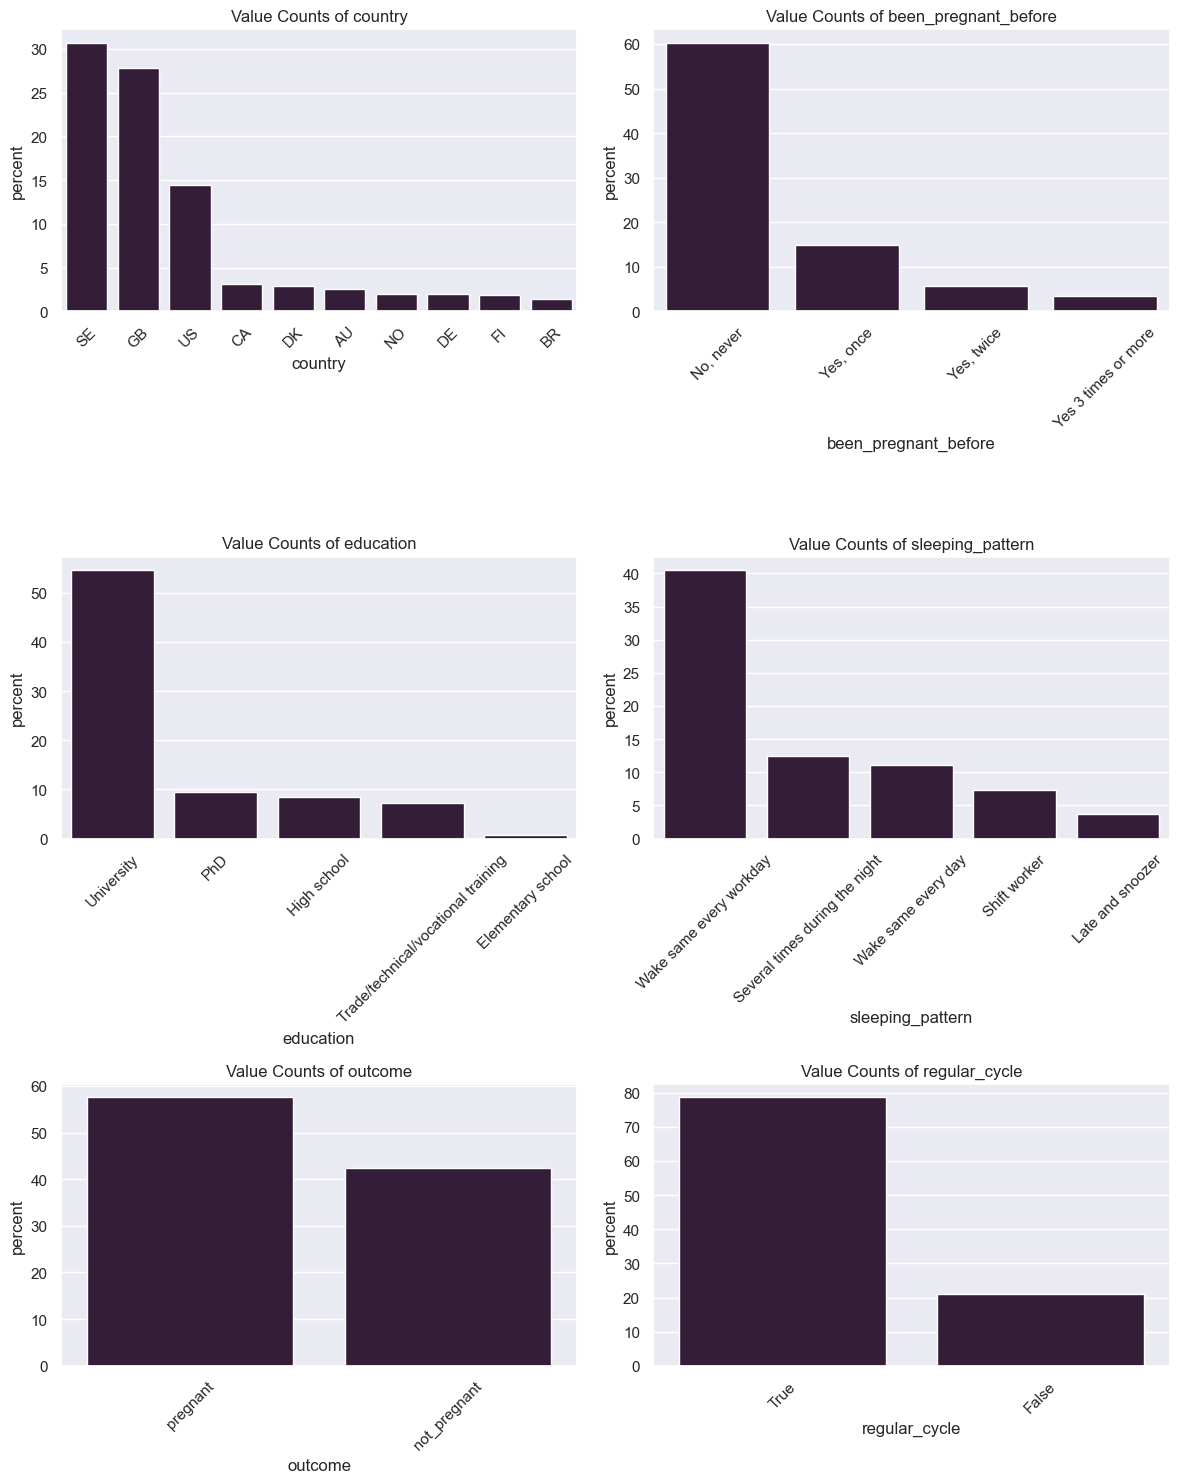

In [4]:
## visualize non-numeric columns
raw_data_categorical_df = raw_data_df.select_dtypes(exclude= np.number)
fig , axs = plt.subplots(3,2,figsize = (12,15))     # set up 2 x 2 frame count plot with figsize 10 x 10
for col , subplots in zip (raw_data_categorical_df, axs.flatten()):
        sns.countplot(data=raw_data_categorical_df, x=raw_data_categorical_df[col],order=raw_data_categorical_df[col].value_counts().iloc[:10].index, stat="percent", ax=subplots)
        subplots.set_title(f'Value Counts of {col}')
        subplots.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


This visualization gives an insight into the demographics of the participants in the dataset.
We oberve that most of the data (~70%) comes from 3 countries (Sweden, Britain and US). Majority of the women (~60%) are xxxx.
More than half of the women have a University education, and were pregnant after n_cycles. Furthermore, majority (~80%) have regular cycles.


## Feature Engineering

In this section, we do some basic feature engineering like data imputation and conversion from categorical variable into numerical

In [5]:
print("Raw data shape", raw_data_df.shape)
print("Shape after dropping NaNs", raw_data_df.dropna().shape)

Raw data shape (1995, 13)
Shape after dropping NaNs (1185, 13)


We observe that we will loose about 40% of data if we blindly drop NaNs. Instead, we dig a little more to see if we can impute any missing data.

In [6]:
## Identify columns with most NaNs
raw_data_df.isnull().sum().sort_values(ascending=False)

sleeping_pattern         499
education                391
been_pregnant_before     317
country                  113
cycle_length_std          25
average_cycle_length       6
regular_cycle              6
bmi                        0
age                        0
n_cycles_trying            0
outcome                    0
dedication                 0
intercourse_frequency      0
dtype: int64

So, we can see that some variables like *country* and *education* can imputed with their most common values, while for *sleeping_pattern* and *pregnant_before* we can replace NaNs by Unkown. This gives us more data for our modeling.

In [14]:
data_df = raw_data_df.copy() ##  Make a copy
data_df['country'] = data_df['country'].fillna(data_df['country'].mode().iloc[0])
data_df['education'] = data_df['education'].fillna(data_df['education'].mode().iloc[0])
data_df[['been_pregnant_before', 'sleeping_pattern']] = data_df[['been_pregnant_before','sleeping_pattern']].fillna("Unknown")

## We drop the numerical columns that have NaN
data_df.dropna(inplace=True)


In [15]:
data_df['outcome'].replace(['pregnant', 'not_pregnant'],[1, 0], inplace=True)

/var/folders/sl/1x56dhz52n1bym1wv3xsjpr00000gn/T/ipykernel_14516/3526233019.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_df['outcome'].replace(['pregnant', 'not_pregnant'],[1, 0], inplace=True)
/var/folders/sl/1x56dhz52n1bym1wv3xsjpr00000gn/T/ipykernel_14516/3526233019.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future

In [16]:
data_df.shape

(1970, 13)

In [18]:
kmf = KaplanMeierFitter()
kmf.fit(data_df['n_cycles_trying'], data_df['outcome'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1970 total observations, 832 right-censored observations>

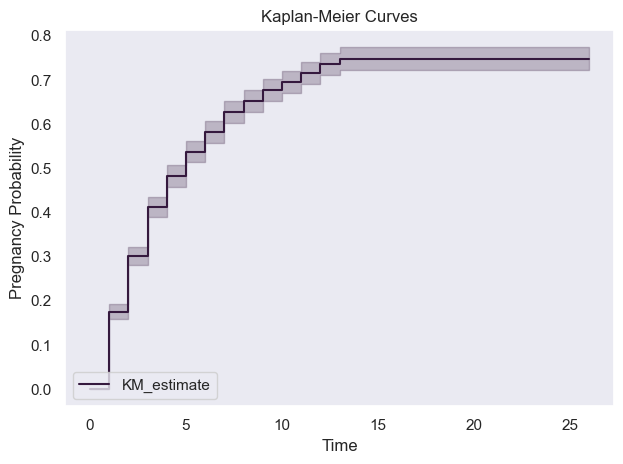

In [19]:
ax = kmf.plot_cumulative_density()
plt.title('Kaplan-Meier Curves')
plt.xlabel('Time')
plt.ylabel('Pregnancy Probability')
#plt.text(10, 0.5, f'Log-rank p-value: {p_value:.4f}', fontsize=12)  # Display p-value on the plot
plt.grid(False)  # Add grid lines
plt.legend(loc='lower left')  # Show legend
plt.tight_layout()  # Adjust layout
plt.show()

In [20]:
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
median_ = kmf.median_survival_time_
print("Number of cycles it usually take to get pregnant:", median_)
print(median_confidence_interval_)
print("Probality of getting pregnant at 13 cycles:", kmf.cumulative_density_at_times(13))

Number of cycles it usually take to get pregnant: 5.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                     4.0                     5.0
Probality of getting pregnant at 13 cycles: 13    0.748632
Name: KM_estimate, dtype: float64
